#  Anomaly detection in cellular networks

## 1. Introduction

The purpose of this notebook is to solve a anomaly detection problem proposed as a competition in the Kaggle InClass platform.

## 2. Problem description

### Context:

Traditionally, the design of a cellular network focuses on the optimization of energy and resources that guarantees a smooth operation even during peak hours (i.e. periods with higher traffic load). 
However, this implies that cells are most of the time overprovisioned of radio resources. 
Next generation cellular networks ask for a dynamic management and configuration in order to adapt to the varying user demands in the most efficient way with regards to energy savings and utilization of frequency resources. 
If the network operator were capable of anticipating to those variations in the users’ traffic demands, a more efficient management of the scarce (and expensive) network resources would be possible.
Current research in mobile networks looks upon Machine Learning (ML) techniques to help manage those resources. 
In this case, you will explore the possibilities of ML to detect abnormal behaviors in the utilization of the network that would motivate a change in the configuration of the base station.


### Objective

The objective of the network optimization team is to analyze traces of past activity, which will be used to train an ML system capable of classifying samples of current activity as:
 - 0 (normal): current activity corresponds to normal behavior of any working day and. Therefore, no re-configuration or redistribution of resources is needed.
 - 1 (unusual): current activity slightly differs from the behavior usually observed for that time of the day (e.g. due to a strike, demonstration, sports event, etc.), which should trigger a reconfiguration of the base station.

### Dataset

The dataset has been obtained from a real LTE deployment. During two weeks, different metrics were gathered from a set of 10 base stations, each having a different number of cells, every 15 minutes. 

The dataset is provided in the form of a csv file, where each row corresponds to a sample obtained from one particular cell at a certain time. Each data example contains the following features:

 - Time : hour of the day (in the format hh:mm) when the sample was generated.
 - CellName1: text string used to uniquely identify the cell that generated the current sample. CellName is in the form xαLTE, where x identifies the base station, and α the cell within that base station (see the example in the right figure).
 - PRBUsageUL and PRBUsageDL: level of resource utilization in that cell measured as the portion of Physical Radio Blocks (PRB) that were in use (%) in the previous 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
 - meanThrDL and meanThrUL: average carried traffic (in Mbps) during the past 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
 - maxThrDL and maxThrUL: maximum carried traffic (in Mbps) measured in the last 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
 - meanUEDL and meanUEUL: average number of user equipment (UE) devices that were simultaneously active during the last 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
 - maxUEDL and maxUEUL: maximum number of user equipment (UE) devices that were simultaneously active during the last 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
 - maxUE_UL+DL: maximum number of user equipment (UE) devices that were active simultaneously in the last 15 minutes, regardless of UL and DL.
 - Unusual: labels for supervised learning. A value of 0 determines that the sample corresponds to normal operation, a value of 1 identifies unusual behavior.

## Libraries

In [1]:
import os
import sys
from zipfile import ZipFile
from IPython.display import Image

#Analysis
import pyspark
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    print('WARN: Something wrong with pyspark library. Please check configuration settings!')
from pyspark.sql.types import StructType, DoubleType, IntegerType, StringType, TimestampType

# Reloads functions each time so you can edit a script and not need to restart the kernel
%load_ext autoreload
%autoreload 2

In [2]:
# # must go first
# %matplotlib inline
# %config InlineBackend.figure_format='retina'

# # plotting
# import matplotlib as mpl
# from matplotlib import pyplot as plt
# import seaborn as sns
# sns.set_context("poster", font_scale=1.3)

# import sys
# import os
# import datetime

# sns.set()
# sns.set_context('poster', font_scale=1.3)
# sns.set_style("white")

# import warnings
# warnings.filterwarnings('ignore')

# # basic wrangling
# import numpy as np
# import yaml
# import json
# import re
# import pandas as pd

# # eda tools
# import pivottablejs
# import missingno as msno

# # Update matplotlib defaults to something nicer
# mpl_update = {
#     'font.size': 16,
#     'xtick.labelsize': 14,
#     'ytick.labelsize': 14,
#     'figure.figsize': [12.0, 8.0],
#     'axes.labelsize': 20,
#     'axes.labelcolor': '#677385',
#     'axes.titlesize': 20,
#     'lines.color': '#0055A7',
#     'lines.linewidth': 3,
#     'text.color': '#677385',
#     'font.family': 'sans-serif',
#     'font.sans-serif': 'Tahoma'
# }
# mpl.rcParams.update(mpl_update)

## Helpers

In [3]:
def get_root_dir(src:str, max_nest:int) -> str:
    '''
    Specify paths and appending directories with relevant python source code.
    '''
    root_dir = os.curdir
    nest = 0
    while src not in os.listdir(root_dir) and nest < max_nest:
        root_dir = os.path.join(os.pardir, root_dir)     # Look up the directory structure for a src directory
        nest += 1
        
    # If you don't find the src directory, the root directory is this directory
    root_dir = os.path.abspath(root_dir) if nest < max_nest else os.path.abspath(
    os.curdir)
    
    return root_dir

def set_src(root_dir:str, src:str) -> str:
    '''
     Get the source directory and append path to access python packages/scripts within directory
    '''
    if src in os.listdir(root_dir):
        src_dir = os.path.join(root_dir, src)
        sys.path.append(src_dir)
    return sys.path[-1]

def set_data(root_dir:str, data:str) -> str:
    '''
    '''
    data_dir = os.path.join(
        root_dir, data) if data in os.listdir(root_dir) else os.curdir
    return data_dir

def set_figures(root_dir:str, figures:str) -> str:
    '''
    '''
    figures_dir = os.path.join(
        root_dir,
        figures) if figures in os.listdir(root_dir) else os.curdir
    return figures_dir
    
def set_models(root_dir:str, models:str) -> str:
    '''
    '''
    models_dir = os.path.join(
        root_dir, models) if models in os.listdir(root_dir) else os.curdir
    return models_dir

def set_path(path:str, dirname:str) -> str:
    '''
    '''
    return os.path.join(path, dirname)

def unzip(inpath:str, outpath:str) -> None:
    zf = ZipFile(inpath, 'r')
    zf.extractall(outpath)
    zf.close()    

# # Prepends the directory path for specifying paths to data or figures
# # dataplus("data.csv") -> "/Users/cmawer/project/data/data.csv"
# # figplus("cool.png") -> "/Users/cmawer/project/figures/cool.png"
# dataplus = lambda x: os.path.join(data_dir, x)
# dataextplus = lambda x: os.path.join(external_data_dir, x)
# figplus = lambda x: os.path.join(figure_dir, x)
# modelsplus = lambda x: os.path.join(models_dir, x)

# # Prepends the date to a string (e.g. to save dated files)
# # dateplus("cool-figure.png") -> "2018-12-05-cool-figure.png"
# now = datetime.datetime.now().strftime("%Y-%m-%d")
# dateplus = lambda x: "%s-%s" % (now, x)

## Setup

In [4]:
root_dir = get_root_dir('src', 5)
src_dir = set_src(root_dir, 'src')
data_dir = set_data(root_dir, 'data')
raw_data_dir = set_path(data_dir, 'raw')
processed_data_dir = set_path(data_dir, 'processed')
figures_dir = set_figures(root_dir, 'figures')
models_dir = set_models(root_dir, 'models')

In [5]:
# To convert to html with collapsible headings and table of contents
# change filename and run cell
# filename = "template.ipynb"
# ! jupyter nbconvert --to html_ch {filename} --template toc2

# 1. Data

In [8]:
train_path = set_path(raw_data_dir, 'ML-MATT-CompetitionQT1920_train.csv')
test_path = set_path(raw_data_dir, 'ML-MATT-CompetitionQT1920_test.csv')
train_data = pd.read_csv(train_path, header=0, sep=',', engine='python') #because UnicodeDecodeError with c engine

## Initiate Spark session

In [14]:
#If not exists create a spark session named Anomaly Detection where the master node is local
spark = SparkSession.builder \
    .master("local[4]") \
    .appName("Anomaly Detection") \
    .getOrCreate()

In [15]:
spark.getActiveSession()

## Extract

### Define schema and read data


In [23]:
schema_train = StructType() \
    .add("Time", StringType(), True) \
    .add("CellName", StringType(), True) \
    .add("PRBUsageUL", DoubleType(), True) \
    .add("PRBUsageDL", DoubleType(), True) \
    .add("meanThr_DL", DoubleType(), True) \
    .add("meanThr_UL", DoubleType(), True) \
    .add("maxThr_DL", DoubleType(), True) \
    .add("maxThr_UL", DoubleType(), True) \
    .add("meanUE_DL", DoubleType(), True) \
    .add("meanUE_UL", DoubleType(), True) \
    .add("maxUE_DL", DoubleType(), True) \
    .add("maxUE_UL", DoubleType(), True) \
    .add("maxUE_UL+DL", IntegerType(), True) \
    .add("Unusual", IntegerType(), True)

train_df = spark.read.option("header", True) \
                .option("delimiter", ',') \
                .schema(schema_train) \
                .csv(train_path)

In [24]:
schema_test = StructType() \
    .add("Time", StringType(), True) \
    .add("CellName", StringType(), True) \
    .add("PRBUsageUL", DoubleType(), True) \
    .add("PRBUsageDL", DoubleType(), True) \
    .add("meanThr_DL", DoubleType(), True) \
    .add("meanThr_UL", DoubleType(), True) \
    .add("maxThr_DL", DoubleType(), True) \
    .add("maxThr_UL", DoubleType(), True) \
    .add("meanUE_DL", DoubleType(), True) \
    .add("meanUE_UL", DoubleType(), True) \
    .add("maxUE_DL", DoubleType(), True) \
    .add("maxUE_UL", DoubleType(), True) \
    .add("maxUE_UL+DL", IntegerType(), True) 

test_df = spark.read.option("header", True) \
                .option("delimiter", ',') \
                .schema(schema_test) \
                .csv(test_path)

In [25]:
train_df.printSchema()

root
 |-- Time: string (nullable = true)
 |-- CellName: string (nullable = true)
 |-- PRBUsageUL: double (nullable = true)
 |-- PRBUsageDL: double (nullable = true)
 |-- meanThr_DL: double (nullable = true)
 |-- meanThr_UL: double (nullable = true)
 |-- maxThr_DL: double (nullable = true)
 |-- maxThr_UL: double (nullable = true)
 |-- meanUE_DL: double (nullable = true)
 |-- meanUE_UL: double (nullable = true)
 |-- maxUE_DL: double (nullable = true)
 |-- maxUE_UL: double (nullable = true)
 |-- maxUE_UL+DL: integer (nullable = true)
 |-- Unusual: integer (nullable = true)



In [26]:
train_df.show(5)

+-----+--------+----------+----------+----------+----------+---------+---------+---------+---------+--------+--------+-----------+-------+
| Time|CellName|PRBUsageUL|PRBUsageDL|meanThr_DL|meanThr_UL|maxThr_DL|maxThr_UL|meanUE_DL|meanUE_UL|maxUE_DL|maxUE_UL|maxUE_UL+DL|Unusual|
+-----+--------+----------+----------+----------+----------+---------+---------+---------+---------+--------+--------+-----------+-------+
|10:45|   3BLTE|    11.642|     1.393|      0.37|     0.041|   15.655|    0.644|    1.114|    1.025|     4.0|     3.0|          7|      1|
| 9:45|   1BLTE|    21.791|     1.891|     0.537|     0.268|   10.273|    1.154|    1.353|    1.085|     6.0|     4.0|         10|      1|
| 7:45|   9BLTE|     0.498|     0.398|     0.015|      0.01|    0.262|    0.164|    0.995|    0.995|     1.0|     1.0|          2|      1|
| 2:45|   4ALTE|     1.891|     1.095|      0.94|     0.024|   60.715|    0.825|    1.035|    0.995|     2.0|     2.0|          4|      1|
| 3:30|  10BLTE|     0.303|

## Transform

Because we have:

 - a particular time format (hh:mm)
 - a composed cell identifier (xαLTE)
 - a messy name (maxUE_UL+DL)
 - missing values
 - unbalanced sample
 
we need to implement some transformations:

 - we have to format the column e.g HH:mm
 - I would leave the cell indentifier because we want to optimize for cell
 - rename maxUE_UL+DL in maxUE_UL_DL
 - we could consider drop missings for simplicity
 - we may assign weights for each class to penalize the majority class (experiment)


In [35]:
flt = """
PRBUsageUL IS NOT NULL
and PRBUsageDL IS NOT NULL
and meanThr_DL IS NOT NULL
and meanThr_UL IS NOT NULL
and maxThr_DL IS NOT NULL
and maxThr_UL IS NOT NULL
and meanUE_DL IS NOT NULL
and meanUE_UL IS NOT NULL
and maxUE_DL IS NOT NULL
and maxUE_UL IS NOT NULL
and maxUE_UL_DL IS NOT NULL
and Unusual IS NOT NULL
"""

item = split(col('hour_enc'), ':').getItem(0)
cond = (item == '0') | (item == '1') | (item == '2') | (item == '3') | (item == '4') | (item == '5') | (item == '6') | (item == '7') | (item == '8') | (item == '9')

train_df = train_df.withColumn('hour_enc', concat(col('Time'), lit(":00"))) \
                   .withColumn('timestamp', when(cond, concat(lit("0"), col('hour_enc'))).otherwise(col('hour_enc'))) \
                   .withColumn('hour', split(col('timestamp'), ':').getItem(0)) \
                   .withColumn('minutes', split(col('timestamp'), ':').getItem(1)) \
                   .withColumnRenamed("maxUE_UL+DL","maxUE_UL_DL") \
                   .filter(flt) \
                   .select("CellName", "timestamp", "hour", "minutes", "PRBUsageUL", "PRBUsageDL", 
                           "meanThr_DL", "meanThr_UL", "maxThr_DL", "maxThr_UL", 
                           "meanUE_DL", "meanUE_UL", "maxUE_DL", "maxUE_UL", "maxUE_UL_DL", 
                           "Unusual")



train_df.show(5)
print(f"The new number of rown is {train_df.count()}")

+--------+---------+----+-------+----------+----------+----------+----------+---------+---------+---------+---------+--------+--------+-----------+-------+
|CellName|timestamp|hour|minutes|PRBUsageUL|PRBUsageDL|meanThr_DL|meanThr_UL|maxThr_DL|maxThr_UL|meanUE_DL|meanUE_UL|maxUE_DL|maxUE_UL|maxUE_UL_DL|Unusual|
+--------+---------+----+-------+----------+----------+----------+----------+---------+---------+---------+---------+--------+--------+-----------+-------+
|   3BLTE| 10:45:00|  10|     45|    11.642|     1.393|      0.37|     0.041|   15.655|    0.644|    1.114|    1.025|     4.0|     3.0|          7|      1|
|   1BLTE| 09:45:00|  09|     45|    21.791|     1.891|     0.537|     0.268|   10.273|    1.154|    1.353|    1.085|     6.0|     4.0|         10|      1|
|   9BLTE| 07:45:00|  07|     45|     0.498|     0.398|     0.015|      0.01|    0.262|    0.164|    0.995|    0.995|     1.0|     1.0|          2|      1|
|   4ALTE| 02:45:00|  02|     45|     1.891|     1.095|      0.9

In [38]:
flt = """
PRBUsageUL IS NOT NULL
and PRBUsageDL IS NOT NULL
and meanThr_DL IS NOT NULL
and meanThr_UL IS NOT NULL
and maxThr_DL IS NOT NULL
and maxThr_UL IS NOT NULL
and meanUE_DL IS NOT NULL
and meanUE_UL IS NOT NULL
and maxUE_DL IS NOT NULL
and maxUE_UL IS NOT NULL
and maxUE_UL_DL IS NOT NULL
"""

item = split(col('hour_enc'), ':').getItem(0)
cond = (item == '0') | (item == '1') | (item == '2') | (item == '3') | (item == '4') | (item == '5') | (item == '6') | (item == '7') | (item == '8') | (item == '9')

test_df = test_df.withColumn('hour_enc', concat(col('Time'), lit(":00"))) \
                   .withColumn('timestamp', when(cond, concat(lit("0"), col('hour_enc'))).otherwise(col('hour_enc'))) \
                   .withColumn('hour', split(col('timestamp'), ':').getItem(0)) \
                   .withColumn('minutes', split(col('timestamp'), ':').getItem(1)) \
                   .withColumnRenamed("maxUE_UL+DL","maxUE_UL_DL") \
                   .filter(flt) \
                   .select("CellName", "timestamp", "hour", "minutes", "PRBUsageUL", "PRBUsageDL", 
                           "meanThr_DL", "meanThr_UL", "maxThr_DL", "maxThr_UL", 
                           "meanUE_DL", "meanUE_UL", "maxUE_DL", "maxUE_UL", "maxUE_UL_DL")

test_df.show(5)
print(f"The new number of rown is {test_df.count()}")

+--------+---------+----+-------+----------+----------+----------+----------+---------+---------+---------+---------+--------+--------+-----------+
|CellName|timestamp|hour|minutes|PRBUsageUL|PRBUsageDL|meanThr_DL|meanThr_UL|maxThr_DL|maxThr_UL|meanUE_DL|meanUE_UL|maxUE_DL|maxUE_UL|maxUE_UL_DL|
+--------+---------+----+-------+----------+----------+----------+----------+---------+---------+---------+---------+--------+--------+-----------+
|   6ALTE| 03:00:00|  03|     00|     3.781|     1.493|     0.575|     0.042|   22.659|    0.743|    0.985|     0.01|     3.0|     2.0|          5|
|   6ULTE| 20:30:00|  20|     30|     2.021|     3.335|     0.569|     0.075|   29.265|    1.049|    1.314|     0.01|     6.0|     3.0|          9|
|   2ALTE| 11:30:00|  11|     30|     0.505|     0.404|     0.014|      0.01|    0.227|    0.097|    1.011|     0.01|     2.0|     1.0|          3|
|   3CLTE| 06:45:00|  06|     45|     1.011|     0.505|     0.238|     0.021|   20.962|    0.609|    1.011|    1

## Load

I don't have a load actually. But I can store it in csv file for now.

In [39]:
processed_train_path = set_path(processed_data_dir, 'ML-MATT-CompetitionQT1920_train_processed.csv')
processed_test_path = set_path(processed_data_dir, 'ML-MATT-CompetitionQT1920_test_processed.csv')
# Suppose to work
# train_df.repartition(1).write.mode('overwrite').format('csv').options(header=True, delimiter=',').save('../../data/processed/ML-MATT-CompetitionQT1920_train_processed.csv')
train_df.toPandas().to_csv(processed_train_path, index=False)
test_df.toPandas().to_csv(processed_test_path, index=False)

# 2. Analysis



Based on the context, I expect:
 - different trends in level of resource utilization when we have anomalies. Both in download and in upload
 - different trends in traffic. Both in download and in upload
 - different trends in usage. Both in download and in upload
    

In [40]:
## Check how import VA report in Jupyter notebook
# %%html
# <iframe src="http://viyalab/reportImages/directImage?reportUri=%2Freports%2Freports%2Ff72f28f9-a6ec-4a6b-a89e-b2802673d644&size=1200x1000&layoutType=entireSection&sectionIndex=0"></iframe>

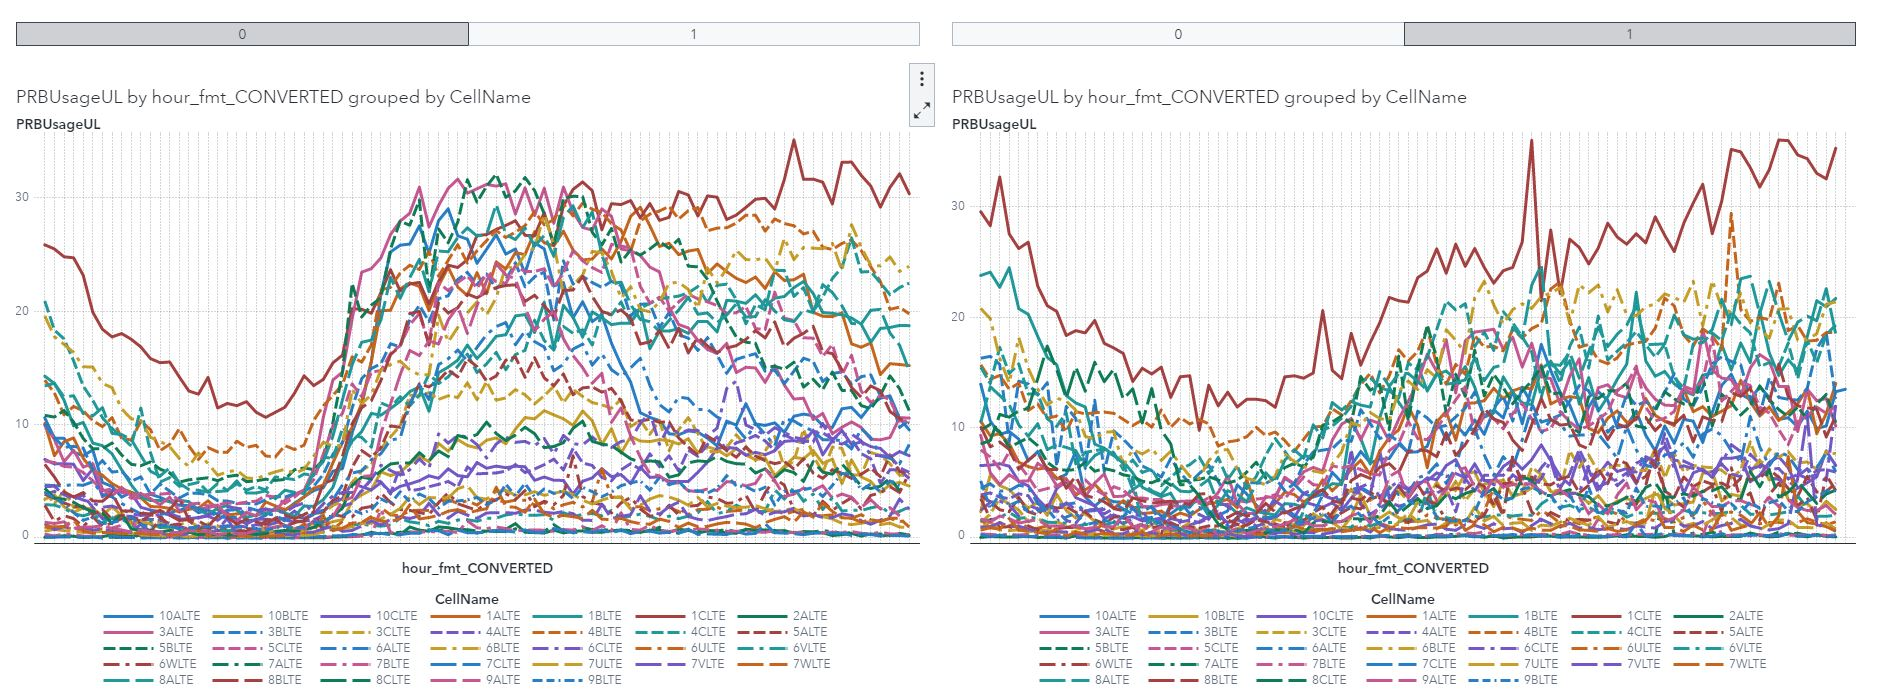

In [41]:
Image(filename = figures_dir + '\\1_PRB_UL_Hour_Cell.JPG')

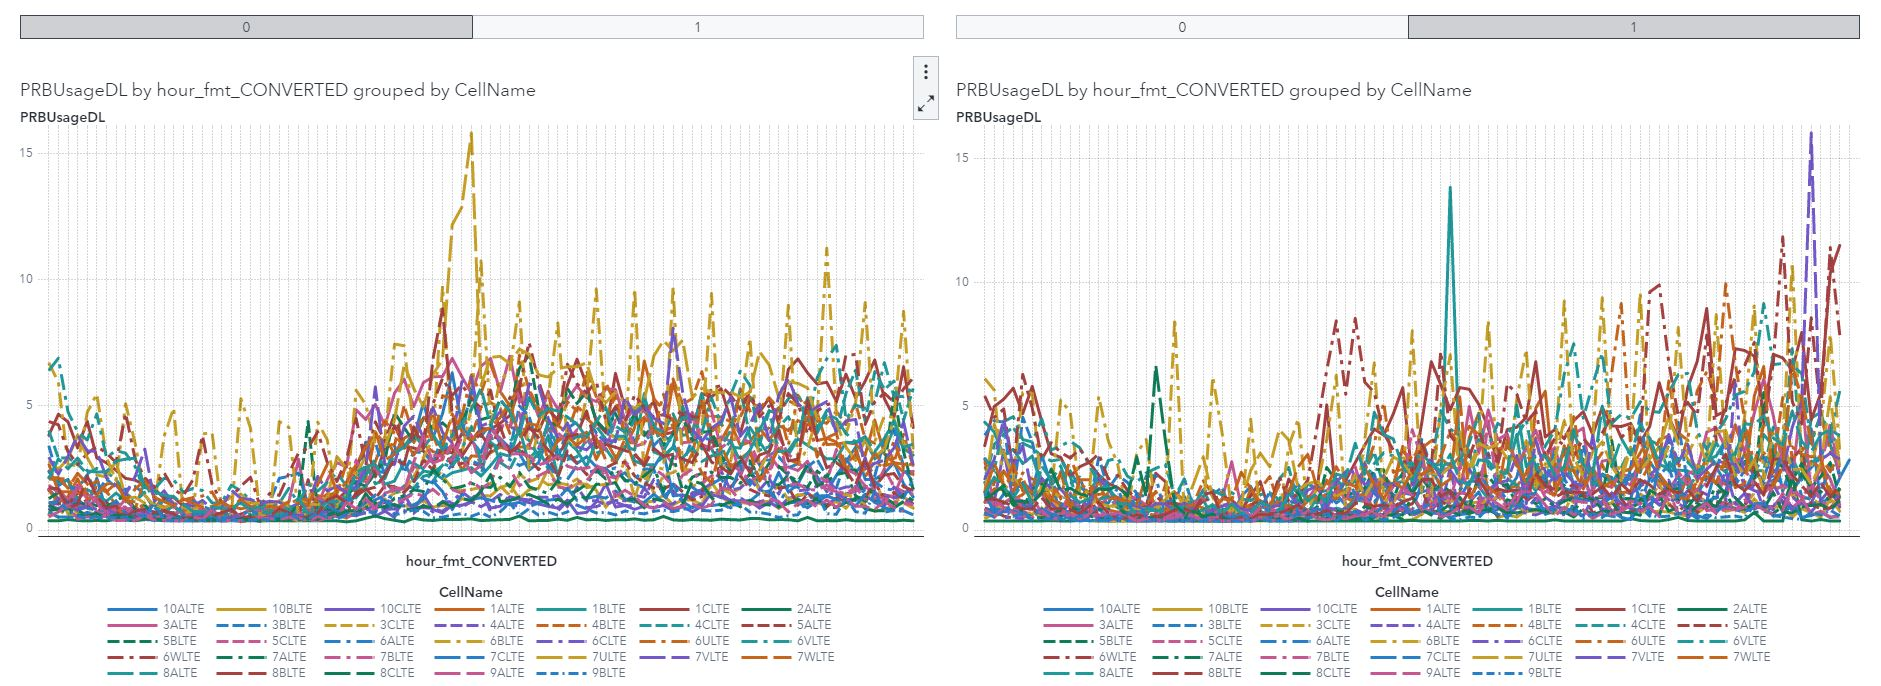

In [43]:
Image(filename = figures_dir + '\\2_PRB_DL_Hour_Cell.JPG')

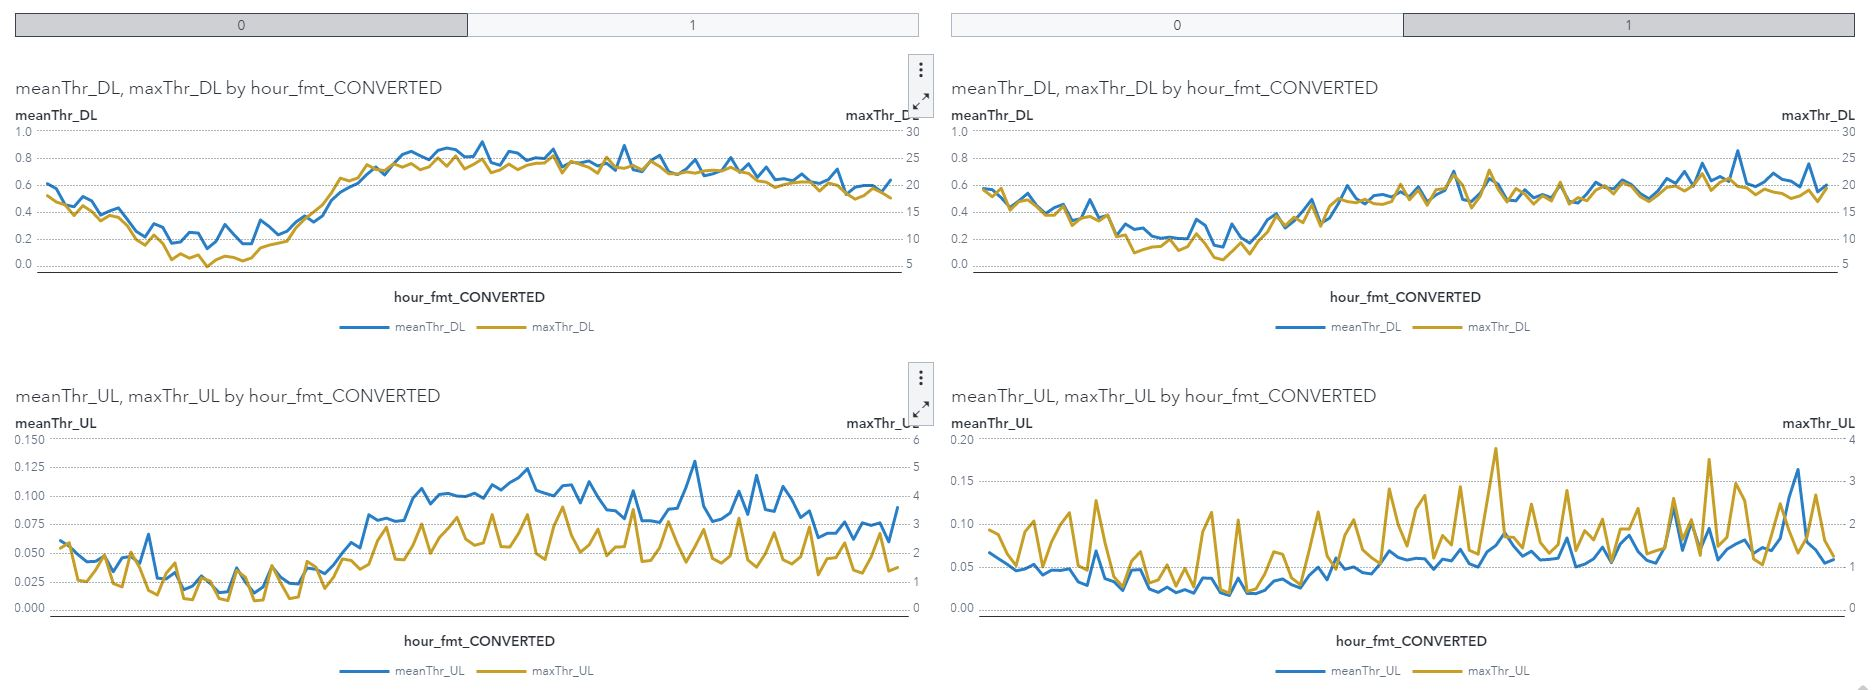

In [45]:
Image(filename = figures_dir + '\\3_mean_max_DL_UL_Usage_0_1.JPG')

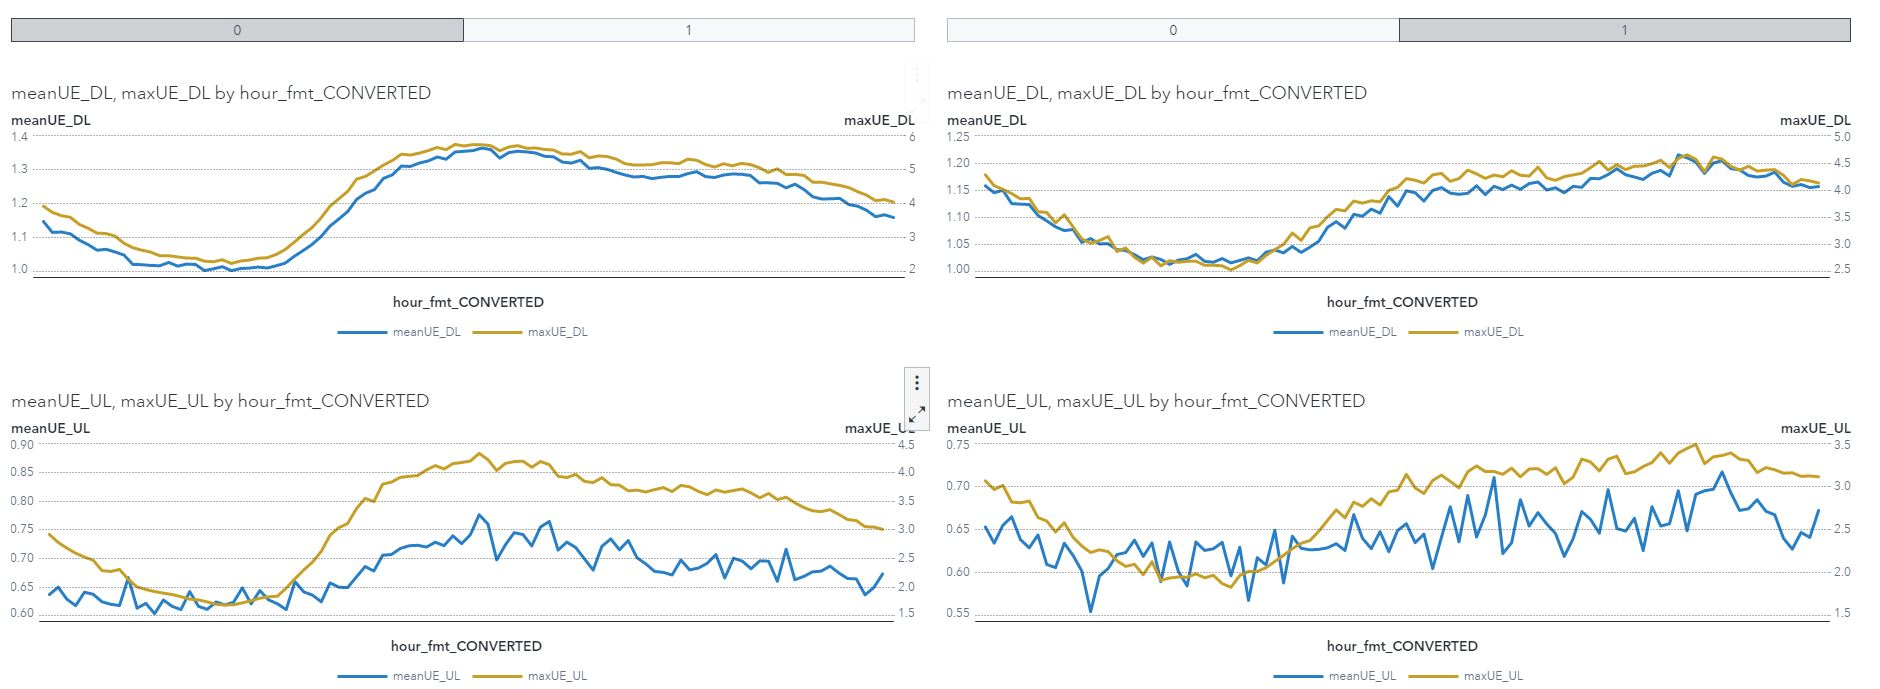

In [47]:
Image(filename = figures_dir + '\\4_mean_max_DL_UL_Thr_0_1.JPG')

# Conclusions

## Key findings 
1. Different trends in level of resource utilization when we have anomalies. Both in download and in upload
2. Different trends in traffic. Both in download and in upload
3. Different trends in usage. Both in download and in upload

## Next steps
1. 
2. 